## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Create the dataset [MNIST]

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

In [3]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define the model

In [4]:
import torch
import torch.nn as nn

class VectorQuantizer(nn.Module):
    """
    Instead of quantizing to a single value, each encoded output gets quantized to a vector 
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # Embedding codebook (num_embeddings entries, each of size embedding_dim)
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, x):
        # Flatten the input (B, C, H, W) -> (B*H*W, C)
        flat_input = x.view(-1, self.embedding_dim)
        
        # Compute the distances between input and each embedding
        distances = torch.cdist(flat_input.unsqueeze(0), self.embeddings.weight.unsqueeze(0), p=2).squeeze(0)
        
        # Find the closest embedding for each element in the matrix
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
        # Quantize: replace input with the closest embedding
        quantized = self.embeddings(encoding_indices).view(x.shape)
        
        # Loss to encourage the latent output to stick to discrete codes (commitment loss)
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator for backpropagation
        quantized = x + (quantized - x).detach()
        
        return quantized, loss, encoding_indices

# VQ-VAE Encoder
class VQVAEEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(VQVAEEncoder, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (B, 1, 28, 28) -> (B, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (B, 32, 14, 14) -> (B, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, kernel_size=1)            # (B, 64, 7, 7) -> (B, embedding_dim, 7, 7)
        )
    
    def forward(self, x):
        return self.conv_layer(x)  # Output: (B, embedding_dim, 7, 7)

# VQ-VAE Decoder
class VQVAEDecoder(nn.Module):
    def __init__(self, embedding_dim):
        super(VQVAEDecoder, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # (B, embedding_dim, 7, 7) -> (B, 64, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),            # (B, 64, 14, 14) -> (B, 32, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),                               # (B, 32, 28, 28) -> (B, 1, 28, 28)
            nn.Sigmoid()  # Output range [0, 1]
        )

    def forward(self, x):
        return self.conv_layer(x)

# VQ-VAE Model
class VQVAE(nn.Module):
    def __init__(self, embedding_dim=64, num_embeddings=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = VQVAEEncoder(embedding_dim)
        self.decoder = VQVAEDecoder(embedding_dim)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
    
    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)  # Output: (B, embedding_dim, 7, 7)
        
        # Quantize each element in the 7x7 feature map
        quantized, vq_loss, _ = self.quantizer(encoded)
        
        # Decode the quantized representation
        reconstructed = self.decoder(quantized)
        
        return reconstructed, vq_loss


## Define training procedure

In [5]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
OPTIMIZER_LR = 1e-3

In [7]:
# Load the data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Model, optimizer
reconstruction_loss_fn = nn.BCELoss()
vqvae = VQVAE().to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=OPTIMIZER_LR)

In [9]:
# Training loop
vqvae.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)

        reconstructed, vq_loss = vqvae(data)
        reconstruction_loss = reconstruction_loss_fn(reconstructed, data)
        total_loss = reconstruction_loss + vq_loss
        
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch [1/10], Loss: 0.1762
Epoch [2/10], Loss: 0.0356
Epoch [3/10], Loss: 0.0270
Epoch [4/10], Loss: 0.0216
Epoch [5/10], Loss: 0.0184
Epoch [6/10], Loss: 0.0169
Epoch [7/10], Loss: 0.0161
Epoch [8/10], Loss: 0.0154
Epoch [9/10], Loss: 0.0151
Epoch [10/10], Loss: 0.0148


## Evaluate the results [Currently not working]

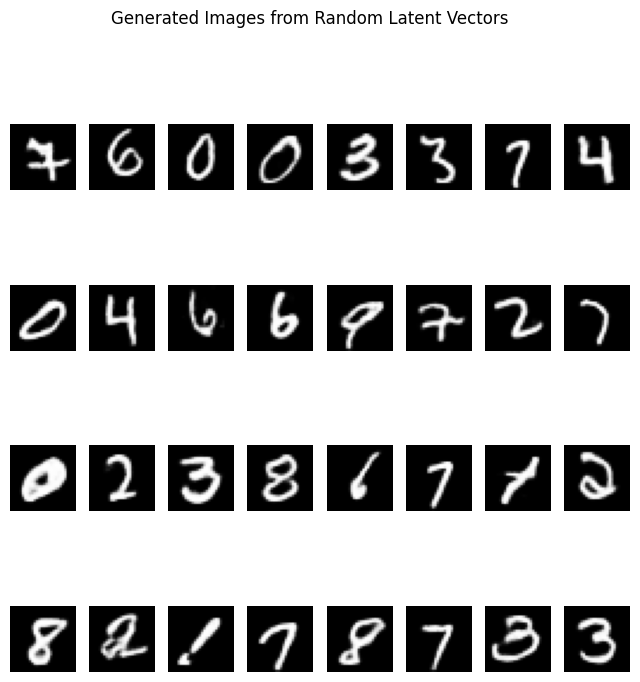

In [28]:
# Reconstructed images of a batch in the training set the generated images in an 8x8 grid
fig, axes = plt.subplots(4, 8, figsize=(8, 8))
for i in range(32):
    row, col = divmod(i, 8)
    axes[row, col].imshow(reconstructed[i][0].detach().cpu().numpy(), cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('Generated Images from Random Latent Vectors')
plt.show()

In [26]:
divmod?

Signature: divmod(x, y, /)
Docstring: Return the tuple (x//y, x%y).  Invariant: div*y + mod == x.
Type:      builtin_function_or_method